# Emotion Recognition from Facial Expressions

In this project, we will be classifying images of peoples' faces into one of seven classes: angry, disgust, fear, happy, neutral, sad, and surprise. We will be using a CNN architecture as our final model.

## Colab Link

https://colab.research.google.com/drive/1DZTNhdpzhPWx8Er2wTWfa8sfFhmRfBM5?usp=sharing

## Initialization

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from google.colab import files
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
import torch.optim as optim
from google.colab import drive
import random

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Unzipping the zipfile of training/test datasets
!unzip /content/drive/MyDrive/emotions_data.zip -d /content/data

Archive:  /content/drive/MyDrive/emotions_data.zip
replace /content/data/test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/test/angry/PrivateTest_10304478.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Training

### Training Function

In [99]:
def training(model, trdata, batchsize = 64, learningrate = 0.01, epochcount = 30):
  # Create the loader from the dataset and use cross entropy loss
  trload = DataLoader(trdata, batch_size=batchsize, shuffle=True)
  criterion = nn.CrossEntropyLoss()
  # use Adam optimizer with the paramters of the cnn and learning rate
  optimizer = optim.Adam(model.parameters(), lr = learningrate)
  # create the datasets
  #trload = DataLoader(dataset, batch_size=batchsize, shuffle=True)
  #valload = DataLoader(valdataset, batch_size=batchsize, shuffle=True)
  # initialize the training and validation error and loss arrays
  trainerr = np.zeros(epochcount)
  trainloss = np.zeros(epochcount)
  trainacc = np.zeros(epochcount)
  model.train()
  # loop through all epochs
  for epoch in range(epochcount):
    # initialize used values to 0
    count = epoch
    tottrloss = 0.0
    tottrerr = 0.0
    totepoch = 0
    correcttr = 0.0
    totaltr = 0.0
    accuarcy = 0.0
    # go through every training image and label
    for i, (imgi, lbli) in enumerate(trload):
      model.train()
      imgi = imgi.float()
      # reset gradients
      optimizer.zero_grad()
      # run the image through the network and compute loss with loss function
      trout = model(imgi)
      trloss = criterion(trout, lbli)
      # calculate gradient
      trloss.backward()
      # update gradient
      optimizer.step()
      _, predicted = torch.max(trout, 1)
      # add to the number of correct and total predictions and loss
      correcttr += (predicted == lbli).sum().item()
      tottrloss += trloss.item()
      totaltr += lbli.size(0)
    # compute the accuracy
    accuracytr = 100 * correcttr / totaltr
    # add to errors and losses (adjusting accuracy and total loss)
    trainerr[epoch] = 1 - (accuracytr/100)
    trainloss[epoch] = float(tottrloss) / (i+1)
    trainacc[epoch] = accuracytr
    # save the model (checkpoint)
    torch.save(model.state_dict(), "model.pth")
    # print the relevant information
    print("Epoch: ", epoch + 1)
    print("Training Accuracy: ", trainacc[epoch], "Training Loss: ", trainloss[epoch]),
  # return the errors and losses
  return trainacc, trainloss

### Testing Function

In [110]:
def testing(model, testdataset, batchsize = 64, learningrate = 0.01, epochcount = 1):
  # Cross Entropy Loss is useful since its a classification problem
  criterion = nn.CrossEntropyLoss()
  # apply Adam optimizer with the given network and set learning rate
  optimizer = optim.Adam(model.parameters(), lr = learningrate)
  # load the data for the testing set, making sure to shuffle the inputs
  teload = DataLoader(testdataset, batch_size=batchsize, shuffle=True)
  # hold the errors and losses
  testerr = np.zeros(epochcount)
  testloss = np.zeros(epochcount)
  testacc = np.zeros(epochcount)
  # initialize the average accuracy
  avaccuracy = 0.0
  # loop through the epochs
  model.eval()
  for epoch in range(epochcount):
    # initialize used values at 0
    count = epoch
    totteloss = 0.0
    totteerr = 0.0
    totepoch = 0
    correctte = 0.0
    totalte = 0.0
    accuarcy = 0.0
    # loop through the data loader, assigning each image and label in it to their
    # respective variables (imgt, lblt)
    for i, (imgt, lblt) in enumerate(teload):
      imgt = imgt.float()
      # run the image through the network and compute the loss using loss function
      teout = model(imgt)
      teloss = criterion(teout, lblt)
      _, predicted = torch.max(teout, 1)
      # Show the first outputted emotion in the batch
      #print(emotion_dict[predicted[0].item()])
      # sum the correct predictions, total predictions, and loss
      correctte += (predicted == lblt).sum().item()
      totteloss += teloss.item()
      totalte += lblt.size(0)
    # compute the accuracy
    accuracyte = 100 * correctte / totalte
    # assign the error (adjusted from accuracy) and loss to their arrays
    testerr[epoch] = 1 - (accuracyte/100)
    testloss[epoch] = float(totteloss) / (i+1)
    testacc[epoch] = accuracyte
    # print the accuracy result
    #print("Epoch: ", epoch + 1)
    #print("Test Accuracy: ", accuracyte, "%")
    avaccuracy += accuracyte
  # compute average accuracy across all epochs and print it
  avaccuracy = avaccuracy / epochcount
  print("Total Test Accuracy: ", avaccuracy, "%")

## Loading Data

### Getting Datasets

The dataset used is the FER-2013 dataset found on Kaggle (https://www.kaggle.com/datasets/msambare/fer2013). The number of training and test images for each class are uneven, so we will cap the amount we use in the following functions.

In [10]:
# Create dictionaries to reference emotions from indices and vice versa
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotion_dict = {i: emotion for i, emotion in enumerate(emotions)}
reverse_emotion_dict = {emotion: index for index, emotion in emotion_dict.items()}

In [11]:
def get_dataset(word):
  imgs = []
  lbls = []
  # Apply cap of lowest number of images for a class in each dataset
  if word == "train":
    cap = 436
  else:
    cap = 111
  # Loop through all images in all folders
  for names in os.listdir('/content/data/{0}'.format(word)):
    count=0
    size = len(os.listdir('/content/data/{0}/{1}'.format(word, names)))
    for name in os.listdir('/content/data/{0}/{1}'.format(word, names)):
      if name.endswith(('.jpg')) and count < cap:
        # Get and save the image
        path = '/content/data/{0}/{1}/{2}'.format(word, names, name)
        img = Image.open(path)
        img = img.convert('RGB')
        img = np.array(img)
        img = img / 255

        lbl = reverse_emotion_dict[names]

        imgs.append(img)
        lbls.append(lbl)
        count+=1
  imgs = np.array(imgs)
  lbls = np.array(lbls)

  imgs = torch.tensor(imgs)
  lbls = torch.tensor(lbls)
  print(imgs.shape)
  imgs = imgs.permute(0, 3, 1, 2)
  data = TensorDataset(imgs, lbls)
  return data

In [12]:
trdata = get_dataset("train")
tedata = get_dataset("test")

train_loader = DataLoader(trdata, batch_size=64, shuffle=True)
test_loader = DataLoader(tedata, batch_size=64, shuffle=True)

torch.Size([3052, 48, 48, 3])
torch.Size([777, 48, 48, 3])


In [13]:
a = [0,0,0,0,0,0,0]
for img, lbl in trdata:
  a[lbl]+=1
print(a)

[436, 436, 436, 436, 436, 436, 436]


## Training

### AlexNet Network

In [ ]:
# Get the alexnet model
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 75.4MB/s]


In [ ]:
# Extract features using alexnet
use_cuda = True
if use_cuda and torch.cuda.is_available():
  alexnet.cuda()
  print('CUDA is available!  restnet_features is on GPU ...')
else:
  print('CUDA is not available.  resnet_features is on CPU ...')
featstr = []
lblalextr = []
featste = []
lblalexte = []
# for each set of data, change the current img using torch.float32 to allow
# it to fit, use torch.no_grad() to reduce the RAM usage and time, and add
# the features/labels to their respective list
for i, (img, lbl) in enumerate(train_loader):
  img = F.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)
  img = img.to(torch.float32)
  with torch.no_grad():
    featurestr = alexnet.features(img)
  featstr.append(featurestr)
  lblalextr.append(lbl)

for i, (img, lbl) in enumerate(test_loader):
  img = F.interpolate(img, size=(224, 224), mode='bilinear', align_corners=False)
  img = img.to(torch.float32)
  with torch.no_grad():
    featureste = alexnet.features(img)
  featste.append(featureste)
  lblalexte.append(lbl)
# concatenate every list to turn it to a tensor
# computed features saved in these variables
featstr = torch.cat(featstr)
featste = torch.cat(featste)
lblalextr = torch.cat(lblalextr)
lblalexte = torch.cat(lblalexte)
print(featstr.shape, featste.shape)

CUDA is not available.  resnet_features is on CPU ...
torch.Size([14357, 256, 6, 6]) torch.Size([3591, 256, 6, 6])


In [10]:
class ALEX(nn.Module):
    def __init__(self):
        super(ALEX, self).__init__()
        self.name = "alex"
        # use 3 conv layers, a step down from CNN's 4
        # kernel = 1, image does not need to be brought down as much
        self.conv1 = nn.Conv2d(256, 512, 1, padding = 1)
        self.conv2 = nn.Conv2d(512, 1028, 1, padding = 1)
        self.conv3 = nn.Conv2d(1028, 2056, 1, padding = 1)
        # pooling layers for interpreting complex information
        self.pool = nn.MaxPool2d(2, 2)
        # dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        # set 4 fully connected layers with appropriate input reciever
        self.fc1 = nn.Linear(8224, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 7)

    def forward(self, x):
        # use ReLU activaion function since its a cnn
        # applying pooling and conv layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 8224)
        # apply dropouts and fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        # make x fit properly
        x = x.squeeze(1)
        return x
alex = ALEX()

In [ ]:
featstr = torch.from_numpy(featstr.detach().numpy())
featstr = featstr.clone().detach()
lblalextr = torch.from_numpy(lblalextr.detach().numpy())
lblalextr = lblalextr.clone().detach()

# create the training and validation datasets and train the alex model
alextraindata = TensorDataset(featstr, lblalextr)
model = alex
model.load_state_dict(torch.load('model.pth'))

### Convolutional Neural Network Model

The AlexNet pretrained model was not as effective, so we turn to the method of direct feeding into a CNN archiecture (FER) to get better results.

In [55]:
class FER(nn.Module):
    def __init__(self):
        super(FER, self).__init__()
        # Set convolutional, batch normalization, pooling, and fully connected layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(in_features=256 * 3 * 3, out_features=512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=512, out_features=7)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)  # Flatten the tensor

        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Epoch:  1
Training Accuracy:  17.595019659239842 Training Loss:  2.2103183368841806
Epoch:  2
Training Accuracy:  20.740498034076015 Training Loss:  2.054062639673551
Epoch:  3
Training Accuracy:  27.85058977719528 Training Loss:  1.9027076934774716
Epoch:  4
Training Accuracy:  31.389252948885975 Training Loss:  1.7652867535750072
Epoch:  5
Training Accuracy:  39.25294888597641 Training Loss:  1.6226137404640515
Epoch:  6
Training Accuracy:  43.54521625163827 Training Loss:  1.5010193263490994
Epoch:  7
Training Accuracy:  49.737876802096984 Training Loss:  1.3392222945888836
Epoch:  8
Training Accuracy:  55.66841415465269 Training Loss:  1.220992570122083
Epoch:  9
Training Accuracy:  62.975098296199214 Training Loss:  0.9980318198601404
Epoch:  10
Training Accuracy:  70.18348623853211 Training Loss:  0.8279824083050092
Epoch:  11
Training Accuracy:  77.62123197903014 Training Loss:  0.6364838213970264
Epoch:  12
Training Accuracy:  79.75098296199214 Training Loss:  0.551501703138152

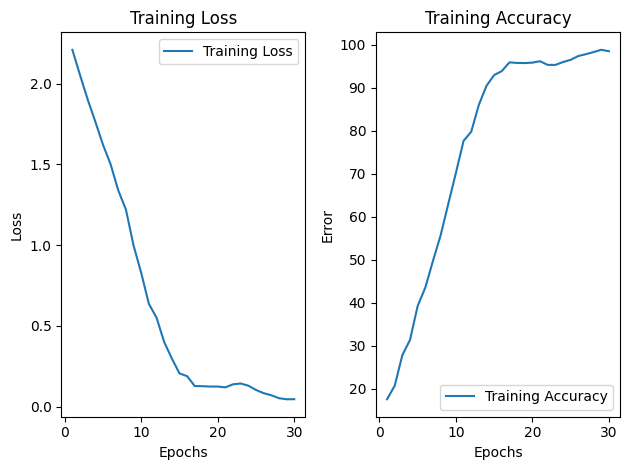

In [15]:
# Train the model and plot the training curves
model = FER()
acctr, losstr = training(model, trdata)

# plot errors and losses
epochlen = range(1, 31)
plt.subplot(1, 2, 1)
plt.plot(epochlen, losstr, label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochlen, acctr, label = 'Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Testing

### Testing with Kaggle Test dataset

In [112]:
# Get the test accuracy of the FER model
model = FER()
model.load_state_dict(torch.load('model.pth'))
testing(model, tedata)

Total Test Accuracy:  78.12097812097812 %


### Testing on New Data

In [82]:
# Using this function, you can upload an image and run it through the model to
# get a prediction
def get_image(model, new_path):
  # Open the image and extract its contents
  new_img = Image.open(new_path)
  new_img = new_img.convert('RGB')
  plt.imshow(new_img)
  new_img = new_img.resize((48,48))

  new_img = np.array(new_img)
  new_img = torch.tensor(new_img).float()
  # Reshape the image to fit into the model
  new_img = new_img.permute(2, 0, 1)
  new_img = new_img.reshape(1, 3, 48, 48)
  # Get the model output
  output = model(new_img)
  _, pred = torch.max(output, 1)
  print("Emotion: ", emotion_dict[pred.item()])

Emotion:  happy


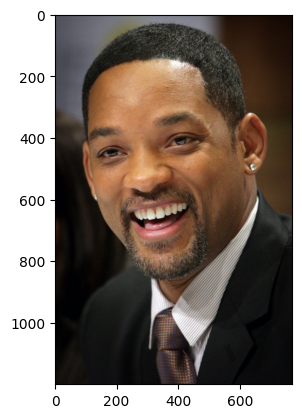

In [83]:
# Upload image/model and set paths to the path to the images
path1 = '/content/Will Smith.jpg'
model = FER()
model.load_state_dict(torch.load('model.pth'))
model.eval()
get_image(model, path1)

Emotion:  fear


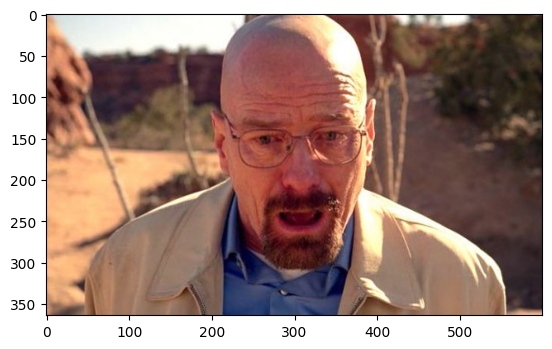

In [84]:
# Upload image/model and set paths to the path to the images
path2 = '/content/Walter White.jpg'
model = FER()
model.load_state_dict(torch.load('model.pth'))
model.eval()
get_image(model, path2)

Emotion:  angry


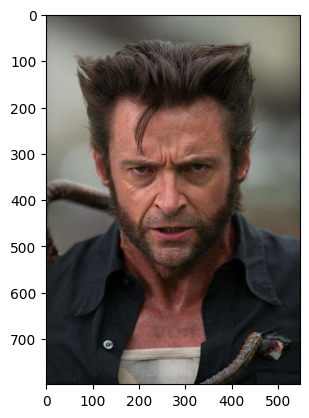

In [96]:
# Upload image/model and set paths to the path to the images
path3 = '/content/Wolverine.jpg'
model = FER()
model.load_state_dict(torch.load('model.pth'))
model.eval()
get_image(model, path3)